In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# makes entire array print by default, 
# can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [4]:
df = acquire_oil()
df = prep_data(df)

# Analyze Data

## Summarize Data

### Data Structure

In [5]:
df.shape

(9111, 37)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9111 entries, 8 to 17144
Data columns (total 37 columns):
api14                 9111 non-null int64
lease_name            9111 non-null object
well_number           9111 non-null object
county                9111 non-null object
type                  9111 non-null category
status                9111 non-null category
oper                  9111 non-null object
multi_well_lease      9111 non-null bool
major_phase           9111 non-null category
formation             9108 non-null object
proppant_ppf          7901 non-null float64
prod_method           9111 non-null category
frac_fluid_gpf        9111 non-null float64
lateral_len           9111 non-null float64
frac_stages           8617 non-null float64
frac_fluid_type       9111 non-null object
first_prod            9111 non-null datetime64[ns]
last_prod             9111 non-null datetime64[ns]
oil_gravity           8871 non-null float64
peak_boepd            9111 non-null float64
oil_hist  

In [7]:
df.sample(3)

,api14,lease_name,well_number,county,type,status,oper,multi_well_lease,major_phase,formation,...,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,lateral_class,vintage,vintage_bin
13462,42383376600000,UNIVERSITY 10-19,6H,REAGAN,Horizontal,Active,pioneer,True,OIL,WOLFCAMP,...,148385,31.253701,-101.481741,145.564842,20.105641,73,1994.038932,eight,2013,4
10120,42329401450000,ST,4406LS,MIDLAND,Horizontal,Active,diamondback exploration & prod llc,True,OIL,SPRABERRY,...,146375,31.959572,-102.221850,191.361335,36.694407,41,4667.349630,six,2015,5
5689,42227386080000,SHROYER-WILSON UNIT A 23-14,1SH,HOWARD,Horizontal,Active,surge operating llc,True,OIL,SPRABERRY,...,144637,32.420456,-101.573655,201.635835,30.090410,38,5306.206193,seven,2016,5


### Data Distributions

In [8]:
print (df.apply(lambda x: x.nunique()))

api14                 9088
lease_name            4067
well_number           3532
county                  40
type                     2
status                   2
oper                   356
multi_well_lease         2
major_phase              3
formation               41
proppant_ppf          7805
prod_method              9
frac_fluid_gpf        8935
lateral_len           4967
frac_stages             63
frac_fluid_type         10
first_prod             503
last_prod              357
oil_gravity            140
peak_boepd            8776
oil_hist              8932
gas_hist              8904
gor_hist              9109
ip90_boeqpd           8965
landing_depth         4305
sur_lat               8821
sur_long              8976
well_id               9111
mid_point_lat         9025
mid_point_long        9030
recovery              9104
recovery_per_foot     9110
months_active          405
recovery_per_month    9038
lateral_class           14
vintage                 59
vintage_bin              5
d

In [9]:
df.describe()

,api14,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,...,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,vintage,vintage_bin
count,9.111000e+03,7901.000000,9111.000000,9111.000000,8617.000000,8871.000000,9111.000000,9111.000000,9111.000000,9111.000000,...,9111.000000,9111.000000,9111.000000,9111.000000,9111.000000,9111.000000,9111.000000,9111.000000,9111.000000,9111.000000
mean,4.220199e+13,1156.279041,1009.888433,5172.729777,2.906812,1.765188,456.920233,114.086108,351.319162,3744.922869,...,-101.987392,138611.010427,31.773551,-101.987553,144.982498,50.362981,70.498628,inf,2010.125672,4.348151
std,9.925261e+11,1538.448069,760.590435,3169.468670,8.989653,8.968751,439.033570,98.094715,384.418922,3849.852441,...,0.734190,19113.569930,0.534110,0.734224,142.761965,100.043607,76.340453,NaN,9.945555,0.882422
min,3.000528e+13,1.098097,0.015129,2.000000,0.000000,0.000000,0.131508,0.026000,0.001000,0.201732,...,-104.340924,88946.000000,30.447167,-104.340768,0.000000,0.000000,0.000000,0.000000,1958.000000,1.000000
25%,4.217337e+13,528.200562,212.993264,2089.000000,0.000000,0.000000,93.252565,36.467500,67.371000,1250.358825,...,-102.254051,142036.500000,31.414950,-102.255215,44.865418,14.224450,33.000000,641.746799,2011.000000,4.000000
50%,4.230133e+13,1157.637700,1054.888000,5043.000000,0.000000,0.000000,363.306100,92.798000,245.713000,2379.901860,...,-101.822388,145332.000000,31.709166,-101.820896,115.696170,23.497067,51.000000,2312.166785,2014.000000,5.000000
75%,4.238336e+13,1598.367550,1587.353150,7622.000000,0.000000,0.000000,677.025604,167.217000,503.609500,4793.533650,...,-101.446261,148607.500000,32.078683,-101.445960,190.867501,42.053703,71.000000,4510.027640,2015.000000,5.000000
max,4.250137e+13,122666.664000,2997.879640,13581.000000,70.000000,68.000000,6118.757000,863.992000,4007.768000,19968.130000,...,-100.056346,157516.000000,33.714024,-100.056315,999.305470,997.824074,726.000000,inf,2018.000000,5.000000


In [10]:
len(df.columns) # 37 features

37

## Standardize Numeric Data

In [11]:
numerics = ['int64', 'float64']

num_df = df.select_dtypes(include=numerics)
num_df.columns

Index(['api14', 'proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist',
       'ip90_boeqpd', 'landing_depth', 'sur_lat', 'sur_long', 'well_id',
       'mid_point_lat', 'mid_point_long', 'recovery', 'recovery_per_foot',
       'months_active', 'recovery_per_month', 'vintage', 'vintage_bin'],
      dtype='object')

In [12]:
num_df = num_df.drop(columns=['gas_hist', 'recovery', 'recovery_per_foot', 
                              'recovery_per_month', 'landing_depth', 'api14',
                             'sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long',
                             'well_id', 'oil_hist'])
num_df.columns

Index(['proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'months_active',
       'vintage', 'vintage_bin'],
      dtype='object')

In [13]:
scaled_df = num_df.copy()
scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['lateral_len'] = (scaled_df.lateral_len - scaled_df.lateral_len.min()) / (scaled_df.lateral_len.max() - scaled_df.lateral_len.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
#scaled_df['oil_hist'] = (scaled_df.oil_hist - scaled_df.oil_hist.min()) / (scaled_df.oil_hist.max() - scaled_df.oil_hist.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())
scaled_df.head()

,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,months_active,vintage,vintage_bin
8,0.001732,0.003263,0.366816,0.000000,NaN,0.030021,0.071056,0.022445,0.132231,0.883333,4
9,0.002055,0.092850,0.382576,0.142857,NaN,0.043365,0.080773,0.016353,0.148760,0.866667,4
10,0.002709,0.106878,0.349289,0.000000,NaN,0.028122,0.087333,0.024103,0.136364,0.866667,4
11,0.008440,0.298529,0.284925,0.000000,NaN,0.005380,0.032051,0.003225,0.128099,0.866667,4
12,0.003216,0.104577,0.278445,0.157143,NaN,0.062559,0.065718,0.074228,0.150138,0.866667,4


In [14]:
xgb_df = scaled_df.copy()

## Visualize Data

### Attribute Histograms

#### XGBoost Feature Recommender

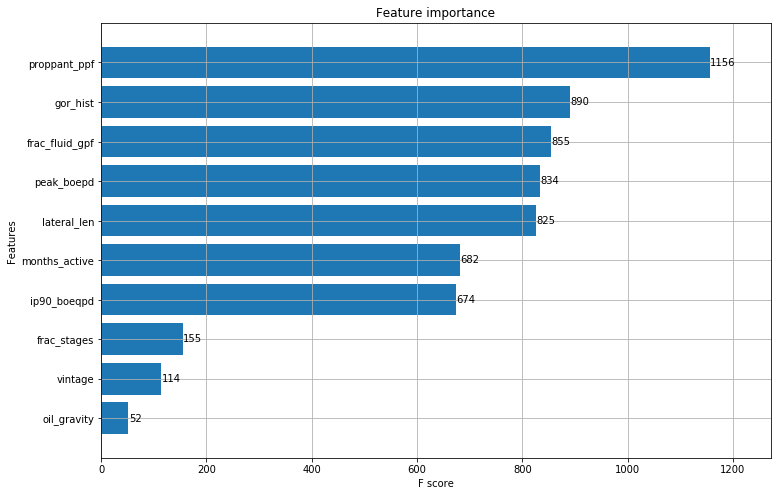

In [15]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

####  PCA (Principal Component Analysis) Feature Recommender

### Pairwise Scatterplots of Attributes